<a href="https://colab.research.google.com/github/giovanni-lucarelli/distribution-shift/blob/main/datasetV02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [106]:
set_seed = 42
np.random.seed(set_seed)

# Dataset Construction

Only one training dataset, three different test sets for different shifting values.


## Function definition

In [107]:
# Conditional probability for binary classifier
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [108]:
# Function to compute a 2D Fourier series
def fourier_surface(x, y, coefficients):
    """
    Computes a Fourier series-based function of two variables.
    :param x: Array of x values.
    :param y: Array of y values.
    :param coefficients: List of tuples (a_k, b_k, c_k) for terms in the series.
    :return: A 2D array representing the surface values.
    """
    z = np.zeros_like(x)
    for (k_x, k_y, a_k, b_k, c_k) in coefficients:
        z += a_k * np.sin(k_x * x + c_k) * np.cos(k_y * y) + b_k * np.cos(k_x * x) * np.sin(k_y * y + c_k)
    return z

In [109]:
#Define coefficients for the Fourier series with smaller k_x and k_y for larger periods

coefficients = [
    (0.1, 0.1, 1.0, 0.8, 0.0),   # k_x = 0.1, k_y = 0.1 (large period)
    (0.2, 0.1, 0.5, 0.4, np.pi / 4),  # k_x = 0.2, k_y = 0.1
    (0.1, 0.2, 0.6, 0.3, np.pi / 6),  # k_x = 0.1, k_y = 0.2
    (0.3, 0.3, 0.2, 0.7, np.pi / 3),  # k_x = 0.3, k_y = 0.3
    (0.2, 0.3, 0.3, 0.2, -np.pi / 4)  # k_x = 0.2, k_y = 0.3
]


**Remark:** the periodicity could be a problem for shift equal to the period

In [110]:
# TODO: pass function z as a parameter
# TODO: generalize to dimension >2

def build_synt_dataset(N, mean, cov, noise_std = 0.3):

  set_seed = 42
  np.random.seed(set_seed)

  x, y = np.random.multivariate_normal(mean, cov, N).T

  # Generating target variable
  z = fourier_surface(x, y, coefficients)

  # gaussian (irreducible) error
  epsilon = np.random.normal(0, noise_std, size=z.shape)
  z_noisy = z + epsilon

  # Probabilità condizionata per i nuovi dati
  prob_t1 = sigmoid(z_noisy)

  # Campionamento della variabile target per i nuovi dati
  t = np.random.binomial(1, prob_t1)

  # Creazione del DataFrame combinato
  df = pd.DataFrame({'x': x, 'y': y, 'z': z_noisy, 't': t})

  return df

### `buid_test_dataset`

In [111]:
def buid_test_dataset(N, prob_for_quant_x, prob_for_quant_y, df_train, cov_shift):
  quantile_x = np.quantile(df_train['x'], prob_for_quant_x)
  quantile_y = np.quantile(df_train['y'], prob_for_quant_y)

  mean_shift = [quantile_x, quantile_y]

  return build_synt_dataset(N, mean_shift, cov_shift)

### useful plot function

In [112]:
def xyzt_plot(df):
  # Visualizzazione combinata
  fig, axs = plt.subplots(1, 3, figsize=(18, 5))

  axs[0].scatter(df['x'], df['z'], alpha=0.6, c= df['z'], label="Marginal x, z")
  axs[0].set_xlabel("X")
  axs[0].set_ylabel("Z")
  axs[0].legend()

  axs[1].scatter(df['y'],  df['z'], alpha=0.6, c= df['z'], label="Marginal y, z")
  axs[1].set_xlabel("Y")
  axs[1].set_ylabel("Z")
  axs[1].legend()

  axs[2].scatter(df['x'], df['y'], c=df['t'], cmap='coolwarm', alpha=0.6, label="Binary Target")
  axs[2].set_xlabel("X")
  axs[2].set_ylabel("Y")
  axs[2].legend()

  plt.tight_layout()
  plt.show()


In [113]:
def xyz3d_plot(df):
  fig = plt.figure(figsize=(18, 5))

  # Create the first subplot in 3D
  ax1 = fig.add_subplot(121, projection='3d')
  ax1.scatter(df['x'], df['y'], df['z'], c=df['z'], cmap='viridis')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.set_zlabel('z')

  # Create the second subplot in 3D
  ax2 = fig.add_subplot(122, projection='3d')
  x = np.linspace(min(df['x']), max(df['x']), 200)
  y = np.linspace(min(df['y']), max(df['y']), 200)
  X, Y = np.meshgrid(x, y)
  Z = fourier_surface(X, Y, coefficients)
  ax2.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_zlabel('Z')

  plt.tight_layout()
  plt.show()

In [114]:
def train_test_plot(df_train, df_test):
  # Create the figure with 3 subplots
  fig = plt.figure(figsize=(18, 6))

  # Subplot 1: 3D Scatterplot
  ax1 = fig.add_subplot(131, projection='3d')
  ax1.scatter(df_train['x'], df_train['y'], df_train['z'], c='blue', label='Original Data', alpha=0.5)
  ax1.scatter(df_test['x'], df_test['y'], df_test['z'], c='red', label='Shifted Data', alpha=0.2)
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.set_zlabel('Z')
  ax1.set_title('3D Scatterplot')
  ax1.legend()

  # Subplot 2: 2D Scatterplot
  ax2 = fig.add_subplot(132)
  ax2.scatter(df_train['x'], df_train['y'], color='blue', label='Train: Original Data', alpha=0.5)
  ax2.scatter(df_test['x'], df_test['y'], color='red', label='Test: Shifted Data', alpha=0.1)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_title('2D Scatterplot of x vs y')
  ax2.legend()
  ax2.grid(True)

  # Subplot 3: KDE Plot
  ax3 = fig.add_subplot(133)
  sns.kdeplot(df_train['x'], color='blue', label='x-TRAIN', fill=True, ax=ax3)
  sns.kdeplot(df_test['x'], color='red', label='x-TEST', fill=True, ax=ax3)
  ax3.set_xlabel('Value')
  ax3.set_ylabel('Density')
  ax3.set_title('Kernel Smoothed Distribution of x and x_shift')
  ax3.legend()

  # Adjust layout
  plt.tight_layout()
  plt.show()


## Training Dataset

In [115]:
# build the train dataset

N = 1000

# Parametri della normale bivariata
mean = [-5, 0]  # Medie
cov = [[10, 0.8], [0.8, 6]]  # Matrice di covarianza

df_train = build_synt_dataset(N, mean, cov)

# check if the classes are balanced
t_counts = df_train['t'].value_counts()
print(t_counts)

t
0    622
1    378
Name: count, dtype: int64


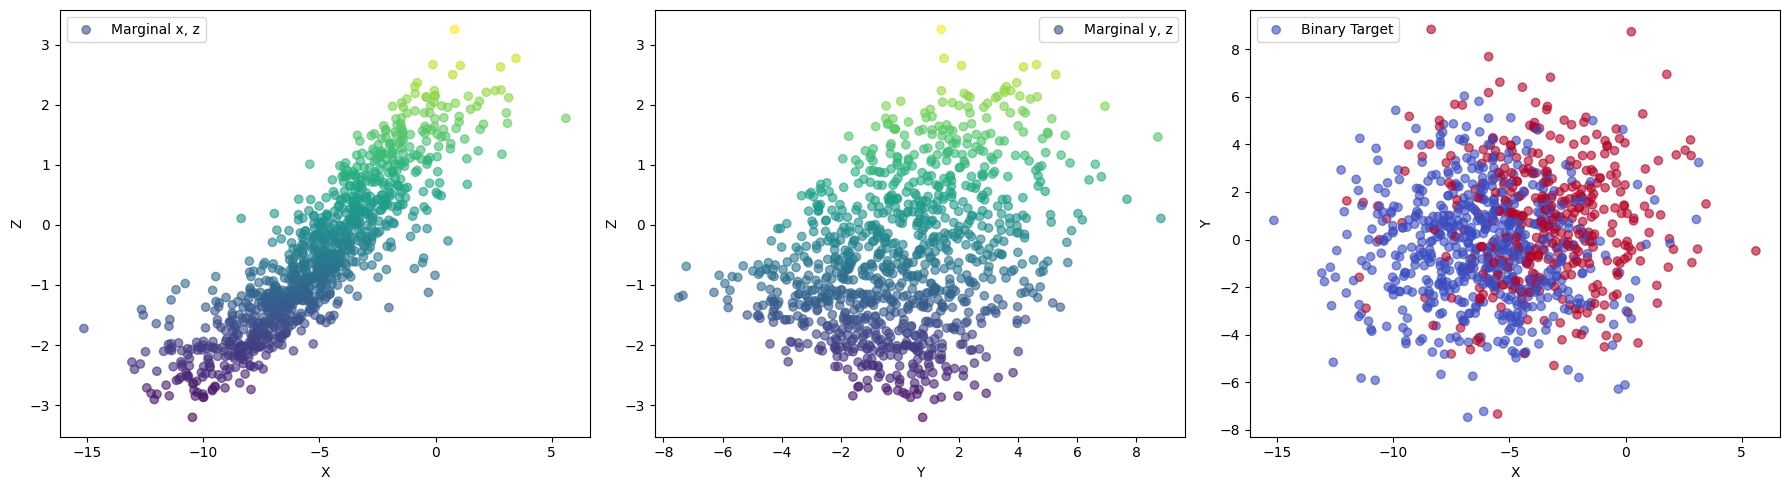

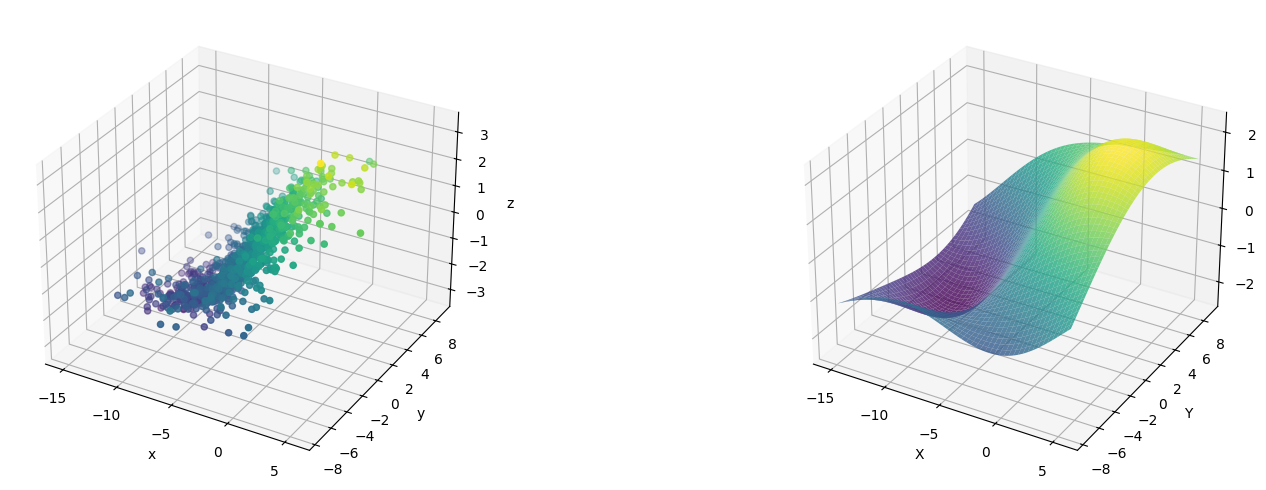

In [116]:
# data visualization
xyzt_plot(df_train)
xyz3d_plot(df_train)

In [117]:
# save train dataset
df_train.to_csv('train.csv', index=False)

## Testing Dataset - 01 shift

In [118]:
# Calculate the empirical quantile
prob_x = 0.01
prob_y = 0.5

cov_shift = [[2, -0.2], [-0.2, 1.2]]

df_test_01 = buid_test_dataset(N, prob_x, prob_y, df_train, cov_shift)

t_counts = df_test_01['t'].value_counts()
print(t_counts)

t
0    918
1     82
Name: count, dtype: int64


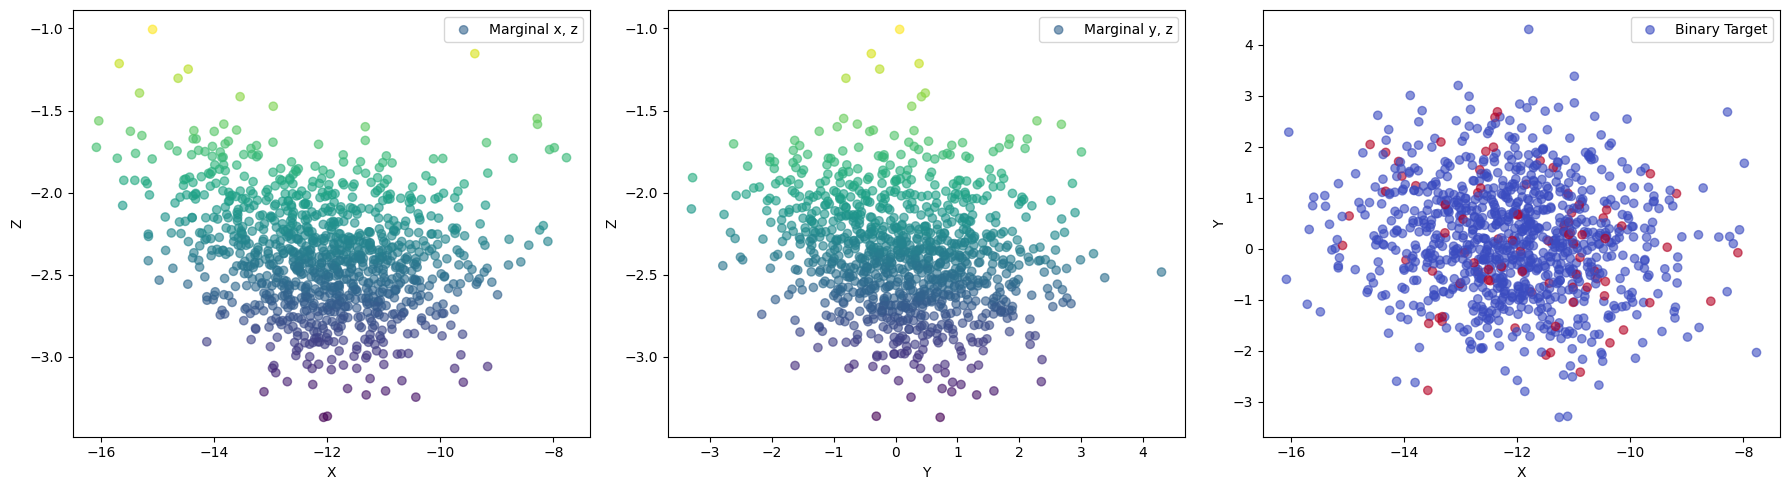

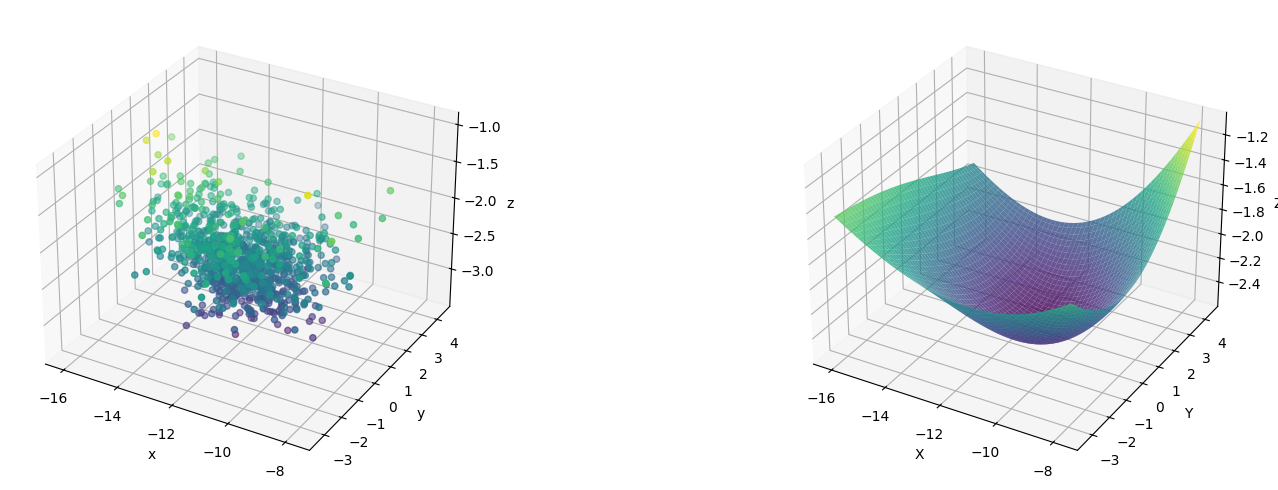

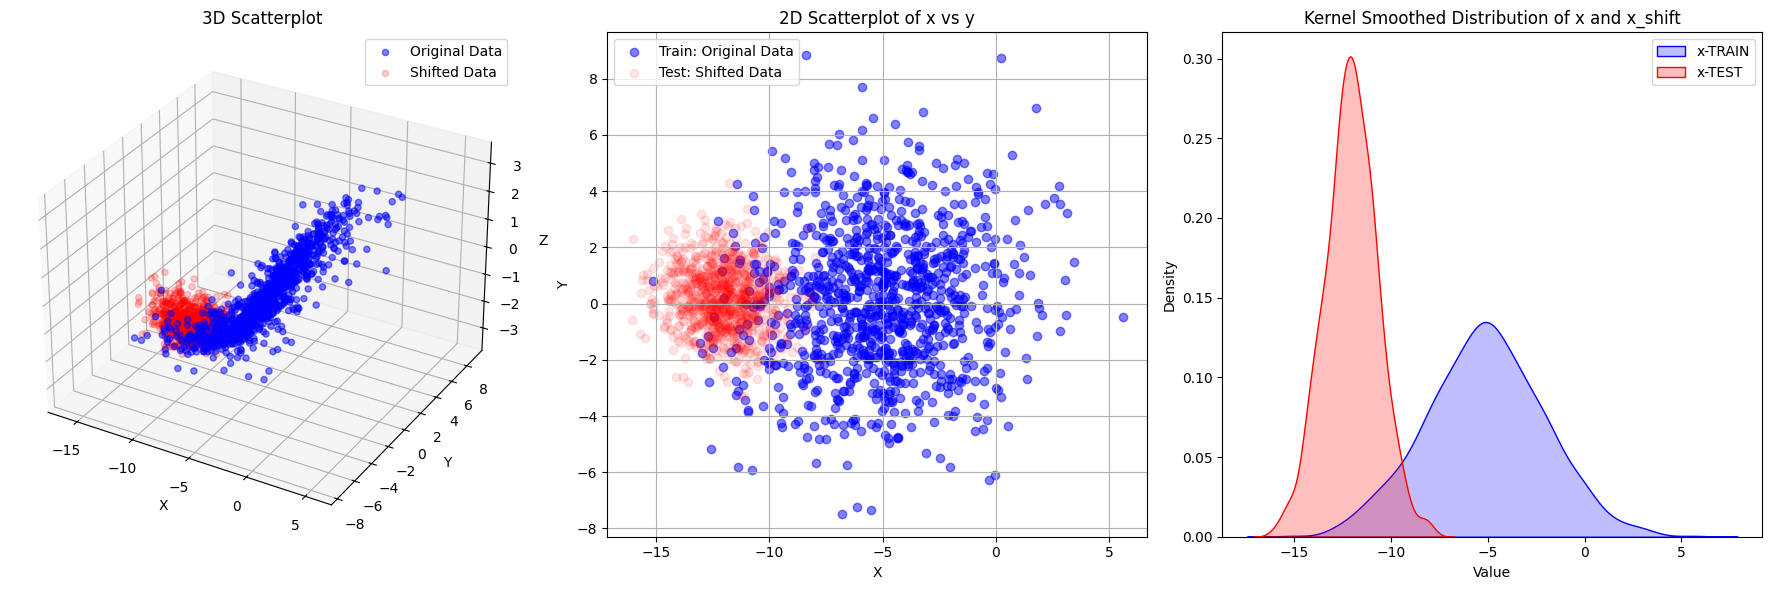

In [119]:
# data visualization
xyzt_plot(df_test_01)
xyz3d_plot(df_test_01)
train_test_plot(df_train, df_test_01)

## Testing Dataset - Different Shifts

Test set class distribution:
t
1    620
0    380
Name: count, dtype: int64


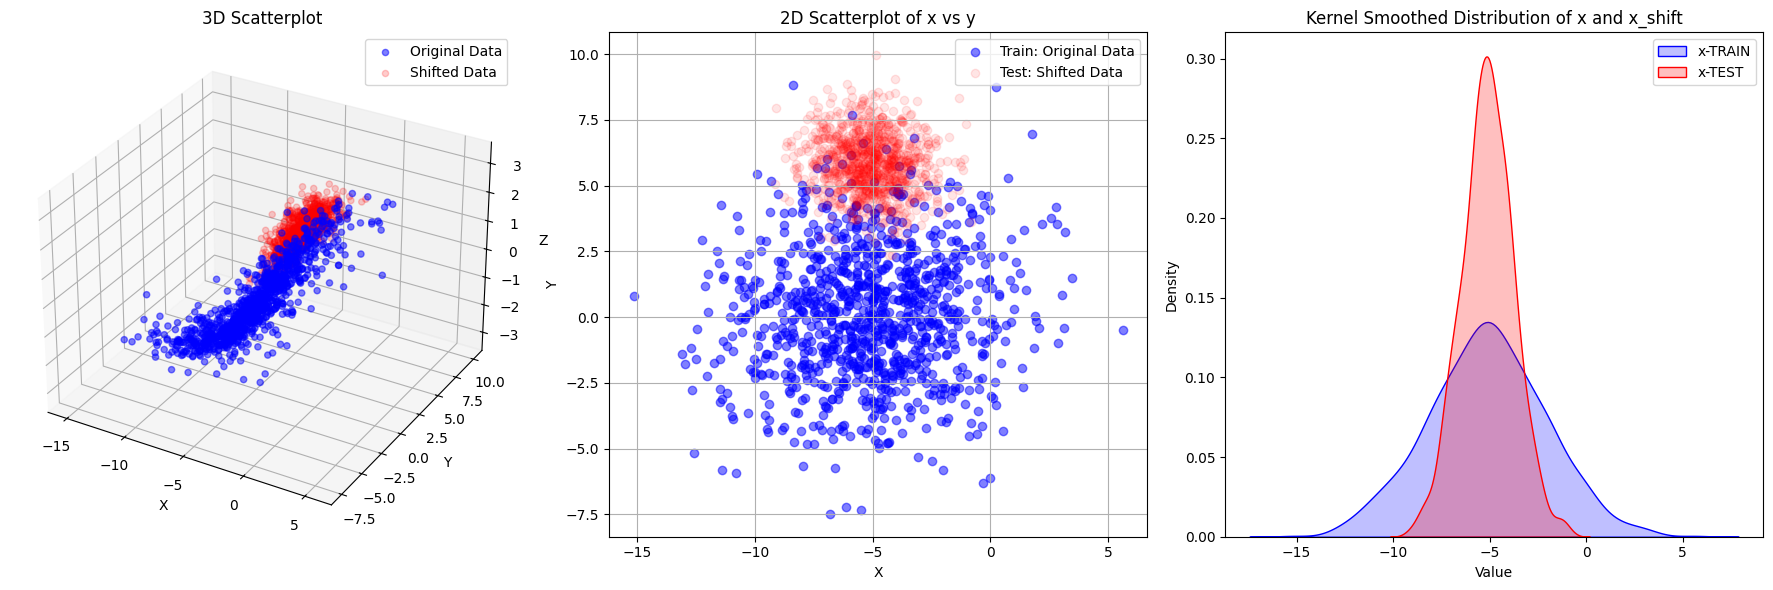

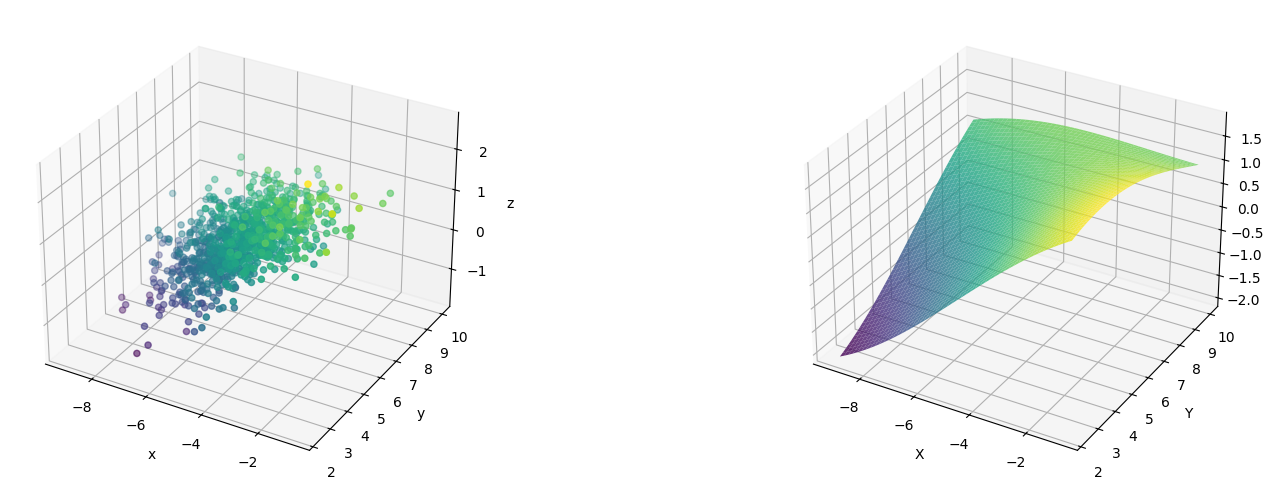

Test set class distribution:
t
1    579
0    421
Name: count, dtype: int64


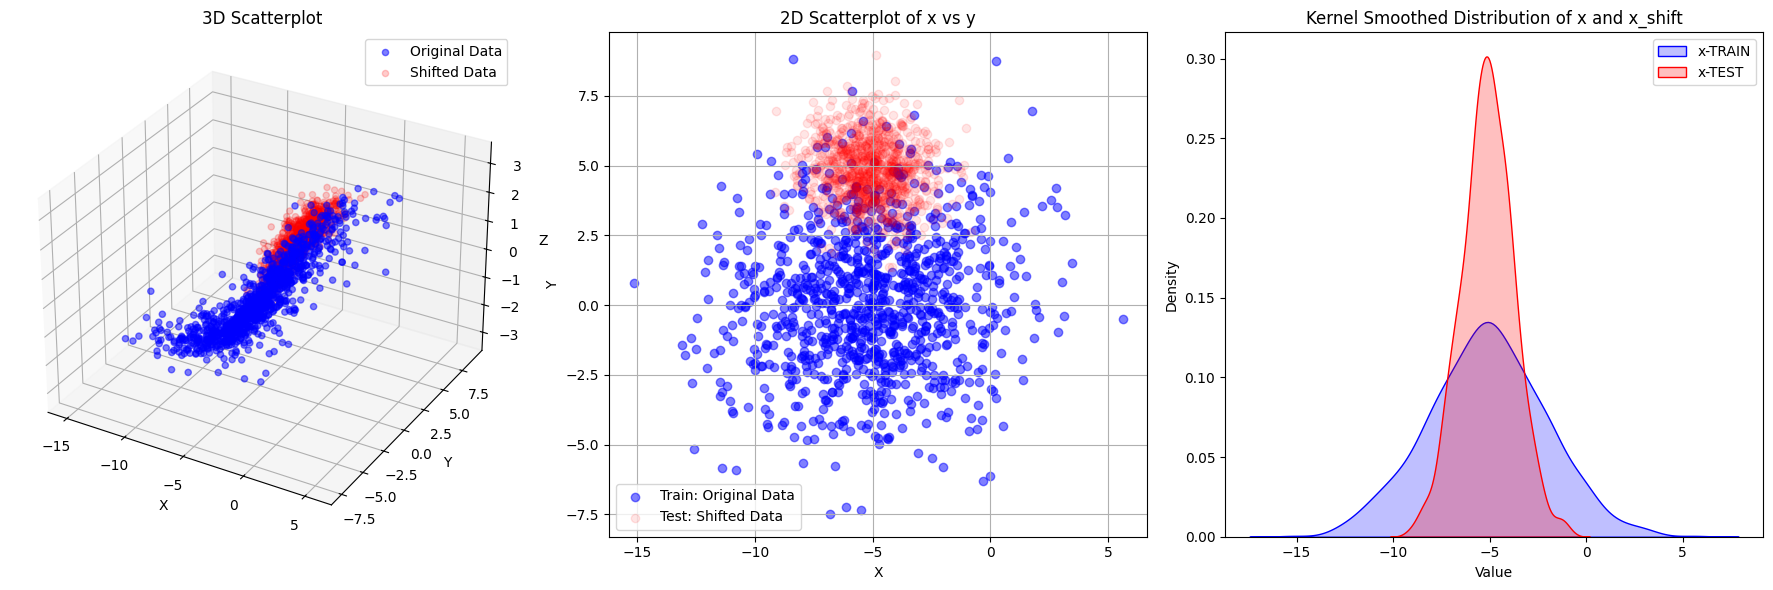

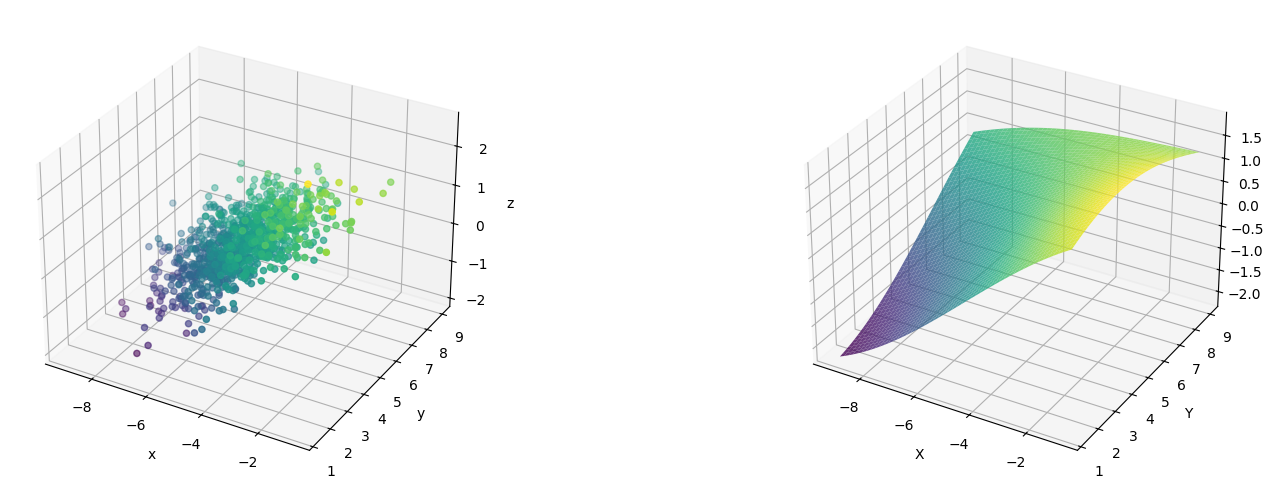

Test set class distribution:
t
1    546
0    454
Name: count, dtype: int64


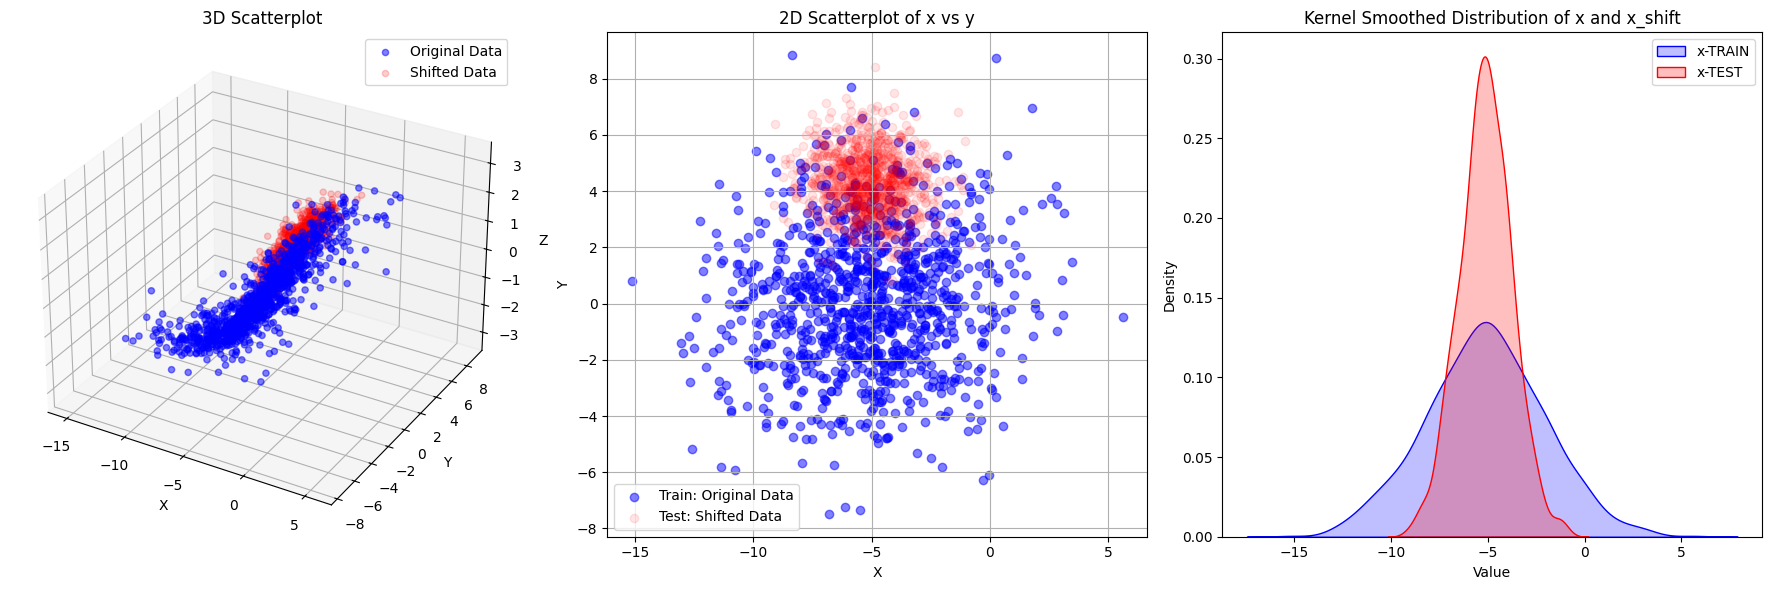

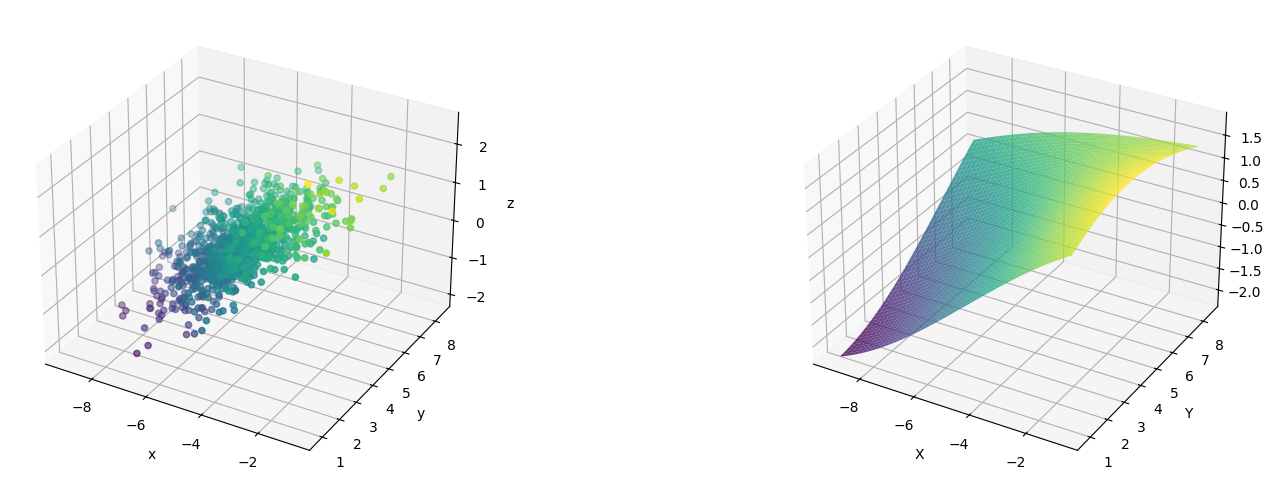

In [122]:
N = 1000
cov_shift = [[2, -0.2], [-0.2, 1.2]]

prob_x = 0.5

for prob_y in [0.99,0.97, 0.95]:
  df_test = buid_test_dataset(N, prob_x, prob_y, df_train, cov_shift)

  # check if the new df is balanced
  print("Test set class distribution:")
  print(df_test['t'].value_counts())

  train_test_plot(df_train, df_test)
  xyz3d_plot(df_test)

  df_test.to_csv(f'test_{prob_y}.csv', index=False)
